# Q-Trading 

In [187]:
import json
import xarray as xr
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import rloutrading as rlou
from importlib import reload
from tqdm.notebook import tqdm

In [216]:
%config InlineBackend.figure_format = "retina"
#%load_ext line_profiler

In [274]:
with open("qtrading-params.json") as f:
    params = json.load(f)
params

{'kappa': 2,
 'sigma': 1.2,
 'xbar': 100,
 'phi': 0.01,
 'gamma': 0.9,
 'c': 0.3,
 'T': 3,
 'dt': 0.1,
 'A': 200000.0,
 'B': 200000.0,
 'C': 200000.0,
 'D': 200000.0}

In [275]:
reload(rlou)
qtr = rlou.QTrading(**params, inventory_min=-10, inventory_max=10)

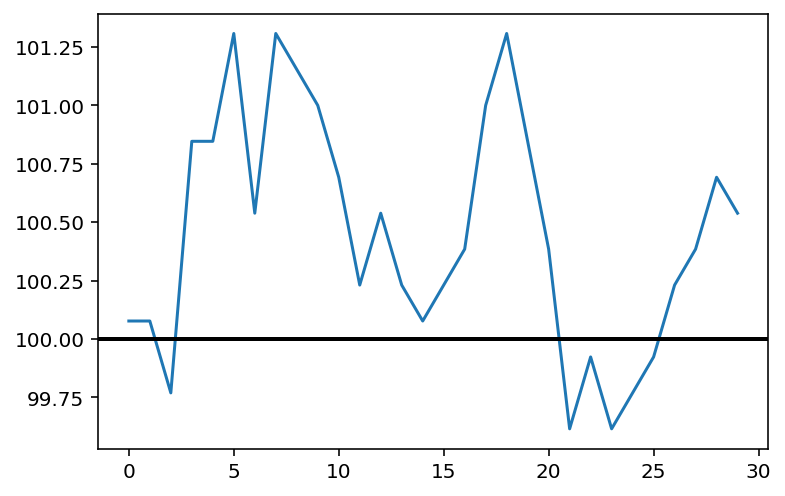

In [276]:
Xt = qtr.simulate_ou_process(nsims=1)
Xt = qtr.buckets[np.digitize(Xt, qtr.buckets)]
plt.plot(Xt)
plt.axhline(y=qtr.xbar, c="black", linewidth=2)

In [ ]:
qtr.q_learn(1_500_000, random_shock=True)

 70%|███████   | 1050371/1500000 [45:03<23:20, 321.04it/s] 

In [ ]:
coords = [qtr.timesteps, qtr.buckets, qtr.inventory, qtr.actions]
dims = ["time", "price", "inventory", "action"]
Qm = xr.DataArray(qtr.Q.copy(), coords=coords, dims=dims)

hm_values = Qm.isel(time=3).argmax(dim="action").to_dataframe("A").reset_index()
hm_values = hm_values.pivot_table(index="price", columns="inventory", values="A") - 5
sns.heatmap(hm_values.sort_index(ascending=False), cmap="RdBu", vmin=-5, vmax=5);

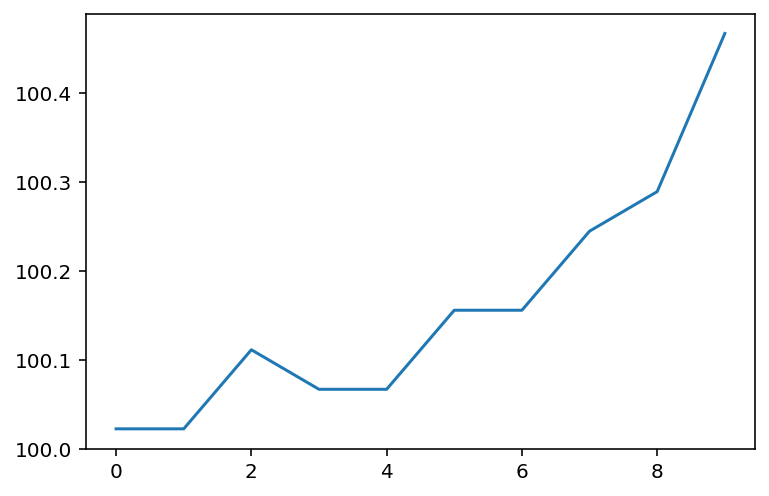

In [117]:
Xt = qtr.simulate_ou_process()
Xt = qtr.buckets[np.digitize(Xt, qtr.buckets)]

plt.plot(Xt)

In [152]:
timesteps = Qm.time.values
q = 0
inventory = np.zeros_like(timesteps)

n_simulations = 5000
PnL = np.empty(n_simulations)
for simulation in tqdm(range(n_simulations)):
    Xt = qtr.simulate_ou_process()
    Xt = qtr.buckets[np.digitize(Xt, qtr.buckets)]
    for i, ti in enumerate(timesteps):
        possible_actions = qtr.get_possible_actions(q)
        action = Qm.sel(time=ti, price=Xt[i], inventory=q, action=possible_actions).idxmax("action").values.max()
        q = q + action
        inventory[i] = q
    
    PnL_sim = (np.diff(Xt.ravel()) * inventory[:-1]).sum()
    PnL[simulation] = PnL_sim

<AxesSubplot:ylabel='Count'>

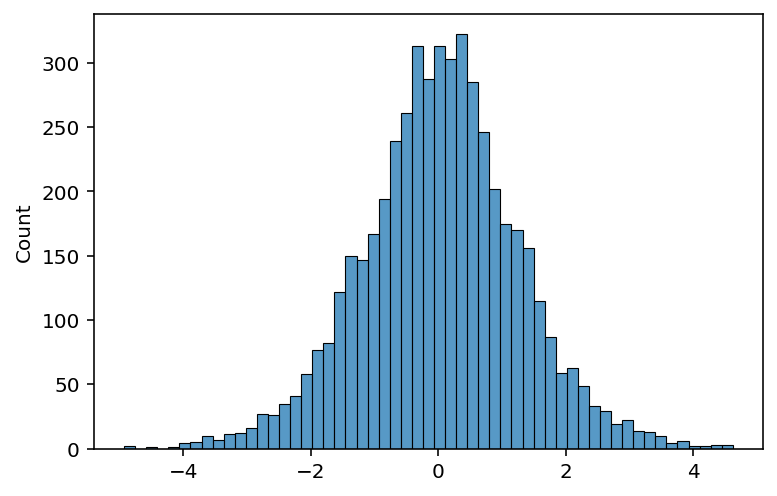

In [154]:
sns.histplot(PnL)

In [157]:
PnL.mean()

0.03645300776544857